### 0. import some package and set global dataset dir and environ
** if you change machine, make sure the path config is right **

In [3]:
import os

# dataset root dir
coins_root = "../dataset/"
swiss_root = coins_root + "swiss-coins/"
os.environ["coins_root"] = coins_root
os.environ["swiss_root"] = swiss_root

rec_dir = swiss_root + "/rec/"

# img2rec python script
# python3_bin_dir = "/root/Util/anaconda3/bin"
#os.environ["im2rec"] = "python /root/Util/miniconda/lib/python2.7/site-packages/mxnet/tools/im2rec.py"
os.environ["im2rec"] = "python /usr/local/lib/python2.7/dist-packages/mxnet/tools/im2rec.py"


### 1. unzip data and reorgnize flolder

### attention:
for swiss coins dataset, train folder is single coin image, and valid folder is multi coin in background image.

In [4]:
! unzip -f $coins_root/swiss-coins.zip -d $swiss_root
! mkdir $swiss_root/train
! mv $swiss_root/*r $swiss_root/*p $swiss_root/train

Archive:  ../dataset//swiss-coins.zip
mkdir: 无法创建目录"../dataset/swiss-coins//train": 文件已存在
mv: 无法获取'../dataset/swiss-coins//*r' 的文件状态(stat): 没有那个文件或目录
mv: 无法获取'../dataset/swiss-coins//*p' 的文件状态(stat): 没有那个文件或目录


### 2. convert image to rec

In [5]:
def mkdir_if_not_exist(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)
def add_value(key, value):
    os.environ[key] = value + ":" + os.environ[key]

def pop_value(key):
    idx = os.environ[key].find(":")
    if idx == -1:
        return None
    else:
        v = os.environ[key][:idx]
        os.environ[key] = os.environ[key][idx+1:]
        return v

#add_value("PATH", python3_bin_dir)
    
mkdir_if_not_exist(rec_dir)
! $im2rec --list True --recursive True --train-ratio 0.9 ${swiss_root}/rec/swiss $swiss_root/train
! $im2rec --num-thread 10 --pass-through 1 ${swiss_root}/rec/swiss $swiss_root/train --encoding=.png

#pop_value("PATH")

10rp 0
1fr 1
20rp 2
2fr 3
50rp 4
back_fr 5
back_rp 6
Creating .rec file from /home/hui/github/CoinCount/dataset/swiss-coins/rec/swiss_train.lst in /home/hui/github/CoinCount/dataset/swiss-coins/rec
time: 0.000580072402954  count: 0
Creating .rec file from /home/hui/github/CoinCount/dataset/swiss-coins/rec/swiss_val.lst in /home/hui/github/CoinCount/dataset/swiss-coins/rec
time: 0.000760078430176  count: 0


### 3. about image.ImageIter (replace io.ImageRecordIter)
image.ImageIter(self, batch_size, data_shape, label_width=1, path_imgrec=None, path_imglist=None, path_root=None, path_imgidx=None, shuffle=False, part_index=0, num_parts=1, aug_list=None, imglist=None, data_name='data', label_name='softmax_label', **kwargs)

1. .rec file has both data and label
2. can use (.lst) path_imglist and path_root to load raw image data
3. if use parition or shuffle, must use .idx file
4. can use aug_list to apply data argument

5. ImageIter分类数据迭代器需要的lst文件格式为<br/>
    id \t label \t path_to_image
    

In [87]:
import mxnet
from mxnet import image
"""
?? image.ImageIter
    To load input images from .rec files, use `path_imgrec` parameter and to load from raw image
    files, use `path_imglist` and `path_root` parameters.
"""
train_data_rec = image.ImageIter(batch_size=8, data_shape=(3, 130, 130),  # load rec in memory
                path_imgrec=rec_dir+"swiss_train.rec")
train_data_lst = image.ImageIter(batch_size=8, data_shape=(3, 130, 130), 
                path_imglist=rec_dir+"swiss_train.lst", path_root=swiss_root+"train/") # load from raw image
train_data_rec_idx = image.ImageIter(batch_size=8, data_shape=(3, 130, 130),  # load rec in memory
                path_imgrec=rec_dir+"swiss_train.rec", path_imgidx=rec_dir+'swiss_train.idx', shuffle=True)

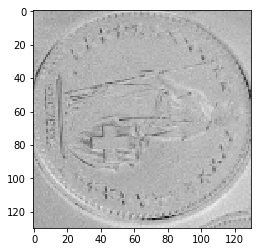

(8, 130, 130, 3) [ 5.  6.  2.  1.  6.  0.  4.  5.]


In [88]:
import matplotlib.pyplot as plt

train_data_rec.reset()
for i, batch in enumerate(train_data_rec):
    data = batch.data[0].transpose((0, 2, 3, 1)).asnumpy()
    label = batch.label[0]
    plt.imshow(data[0])
    plt.show()
    print data.shape, label.asnumpy()
    break

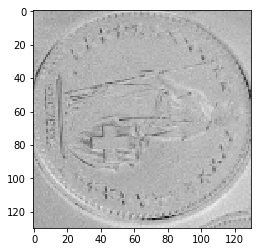

(8, 130, 130, 3) [ 5.  6.  2.  1.  6.  0.  4.  5.]


In [89]:
train_data_lst.reset()
for i, batch in enumerate(train_data_lst):
    data = batch.data[0].transpose((0, 2, 3, 1)).asnumpy()
    label = batch.label[0]
    plt.imshow(data[0])
    plt.show()
    print data.shape, label.asnumpy()
    break

In [90]:
?? image.ImageIter

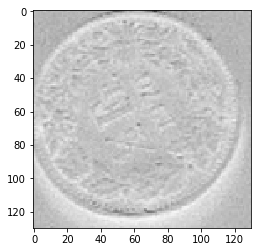

(8, 130, 130, 3) [ 4.  1.  2.  5.  3.  2.  3.  3.]


In [91]:
train_data_rec_idx.reset()
for i, batch in enumerate(train_data_rec_idx):
    data = batch.data[0].transpose((0, 2, 3, 1)).asnumpy()
    label = batch.label[0]
    plt.imshow(data[0])
    plt.show()
    print data.shape, label.asnumpy()
    break

### 4. about image.ImageDetIter
Init signature: image.ImageDetIter(self, batch_size, data_shape, path_imgrec=None, path_imglist=None, path_root=None, path_imgidx=None, shuffle=False, part_index=0, num_parts=1, aug_list=None, imglist=None, data_name='data', label_name='label', **kwargs)</br>

data format

```
?? image.detection

def _parse_label(self, label):
        Helper function to parse object detection label.

        Format for raw label:
        n \t k \t ... \t [id \t xmin\t ymin \t xmax \t ymax \t ...] \t [repeat]
        where n is the width of header, 2 or larger
        k is the width of each object annotation, can be arbitrary, at least 5
```


In [105]:
import os
import shutil
import xml.dom.minidom as d
from PIL import Image

__label_dict = {}
def get_info_from_annotaions_VOC(annopath, normalize=True):
    """
    args:
        annopath: VOC format annotaion file path
        normalzie: whether boxes is normalzie to [0, 1] (/w, /h)
    
    return:
        boxes: ground truth boxes for detection.
        labels: ground truth boxes's class id, same length with boxes.
        w: image width recored in annoaton file.
        h: image height recored in annoaton file.
    """
    def get_label_id(name):
        if not __label_dict.has_key(name):
            __label_dict[name] = len(__label_dict)
        return __label_dict[name]
    
    dom = d.parse(annopath)
    root = dom.documentElement
    
    size = root.getElementsByTagName("size")[0]
    w = float(size.getElementsByTagName('width')[0].childNodes[0].data)
    h = float(size.getElementsByTagName('height')[0].childNodes[0].data)
    
    boxes = []
    labels = []
    for o in root.getElementsByTagName("object"):
        l = get_label_id(o.getElementsByTagName('name')[0].childNodes[0].data)
        bd = o.getElementsByTagName('bndbox')[0];
        x0 = bd.getElementsByTagName('xmin')[0].childNodes[0].data
        y0 = bd.getElementsByTagName('ymin')[0].childNodes[0].data
        x1 = bd.getElementsByTagName('xmax')[0].childNodes[0].data
        y1 = bd.getElementsByTagName('ymax')[0].childNodes[0].data
        if normalize:
            boxes.append([float(x0)/w, float(y0)/ h, float(x1)/w, float(y1)/h])
        else:
            boxes.append([int(x0), int(y0), int(x1), int(y1)])
        labels.append(l)
    return boxes, labels, w, h

def get_info_from_annotaions_SDL(annopath, imgpath, normalize=True):
    """
    args:
        annopath: VOC format annotaion file path
        imgpath: the image path to annotaion file.
        normalzie: whether boxes is normalzie to [0, 1] (/w, /h)
    
    return:
        boxes: ground truth boxes for detection.
        labels: ground truth boxes's class id.
        w: image width recored in annoaton file.
        h: image height recored in annoaton file.
    """
    def get_image_wh(imgpath):
        img = Image.open(imgpath)
        width = img.width
        height = img.height
        return width, height
    
    def split_label(label):
        label = label.strip(' ').strip('\r\n').strip('\n')
        if len(label.split('\t')) >= 9: return label.split('\t')  # not seperate with '\t'
        label = label.split(' ')
        new_label = []
        for l in label:
            if len(l) > 0:
                new_label.append(l)
        return new_label
    
    w, h = get_image_wh(imgpath)
    
    windows = open(annopath).readlines()
    boxes = []
    labels = []
    for label in windows:
        label = split_label(label)
        label = map(lambda x: float(x), label[:-1])
        x1, y1, x2, y2, x3,y3, x4, y4 = label[:8]
        xmin = min([x1, x2, x3, x4])
        ymin = min([y1, y2, y3, y4])
        xmax = max([x1, x2, x3, x4])
        ymax = max([y1, y2, y3, y4])
        if normalize:
            box = (xmin/w, ymin/h, xmax/w, ymax/h)
        else:
            box = (xmin, ymin, xmax, ymax)
        boxes.append(box)
        labels.append(int(label[-1]))
    return boxes, labels, w, h

def get_info_from_annotaions(annopath, fmt, normalize=True, **kwargs):
    if fmt.lower() == "voc":
        return get_info_from_annotaions_VOC(annopath, normalize)
    elif fmt.lower() == "sdl":
        return get_info_from_annotaions_SDL(annopath, kwargs['imgpath'], normalize)
    else:
        raise ValueError("annotation format is not support, annotaion fomrat must be on of [VOC, SDL]")

def list_image_det(lst_file, annotations_root, out_lst_file=None, fmt="VOC", path_root=None):
    """
    lst_file: lst file generate by im2rec.py
    out_lst_file: lst file after modyfied
    annotations_root: annaotaion file's root dir
    fmt: could be 'SDL' or 'VOC'
    """
    # some check
    fmt = fmt.lower()
    if fmt == 'voc':
        ext = ".xml"
    elif fmt == 'sdl':
        if path_root  is None:
            raise ValueError("when data is SDL formt, 'path_root' must specified, it will use to open image.")
        ext = '.txt'
    else:
        raise ValueError("annotation format is not support, 'fmt' must be on of [VOC, SDL]")
    
    def boxes_to_str(boxes, labels):
        s = ""
        for i, box in enumerate(boxes):
            box = [str(it) for it in box]
            s += str(labels[i]) + "\t" + "\t".join(box) + "\t"
        return s[:-1]
    
    lst_f = open(lst_file)
    if out_lst_file is None:
        o_lst_f = open("tmp", 'w')
    else:
        o_lst_f = open(out_lst_file, 'w')
        
    i = 0                           # should be remove when really run
    for line in lst_f.readlines():
        items = line.split('\t')
        imgname = items[-1].split("/")[-1]
        imgname = imgname.split(".")[0]
        
        new_line = items[0] + "\t"
        
        annopath = os.path.join(annotations_root, imgname+ext)
        if fmt == 'voc':
            boxes, labels, w, h = get_info_from_annotaions(annopath, fmt)
        if fmt == 'sdl':
            boxes, labels, w, h = get_info_from_annotaions(annopath, fmt, 
                                                           imgpath=path_root+"/"+items[-1].strip('\n'))
        new_line += "4\t" + str(5*len(boxes)) + "\t" + str(w) + '\t' + str(h) + '\t'
        new_line += boxes_to_str(boxes, labels) + "\t"
        
        new_line += items[-1]
        o_lst_f.write(new_line)
        i += 1                      # should be remove when really run
        if i >= 2: break            # should be remove when really run
    lst_f.close()
    o_lst_f.close()
    
    if out_lst_file is None:
        shutil.move('tmp', lst_file)
    return __label_dict

In [111]:
! $im2rec --list True --recursive True --train-ratio 0.9 ${swiss_root}/rec/swiss $swiss_root/train
print list_image_det(rec_dir + "swiss_train.lst", swiss_root, fmt='sdl', path_root=swiss_root+'/train')#, rec_dir + "swiss_det_train.lst")
! $im2rec --num-thread 10 --pass-through 1 --pack-label True ${swiss_root}/rec/swiss $swiss_root/train --encoding=.png

10rp 0
1fr 1
20rp 2
2fr 3
50rp 4
back_fr 5
back_rp 6
{}
Creating .rec file from /home/hui/github/CoinCount/dataset/swiss-coins/rec/swiss_train.lst in /home/hui/github/CoinCount/dataset/swiss-coins/rec
time: 0.000878095626831  count: 0
Creating .rec file from /home/hui/github/CoinCount/dataset/swiss-coins/rec/swiss_val.lst in /home/hui/github/CoinCount/dataset/swiss-coins/rec
time: 0.000828981399536  count: 0


In [114]:
! $im2rec --list True --recursive True --train-ratio 0.9 ${swiss_root}/rec/swiss $swiss_root/train
print list_image_det(rec_dir + "swiss_train.lst", swiss_root, fmt='VOC')#, rec_dir + "swiss_det_train.lst")
! $im2rec --num-thread 10 --pass-through 1 --pack-label True ${swiss_root}/rec/swiss $swiss_root/train --encoding=.png

10rp 0
1fr 1
20rp 2
2fr 3
50rp 4
back_fr 5
back_rp 6
{u'car': 0}
Creating .rec file from /home/hui/github/CoinCount/dataset/swiss-coins/rec/swiss_train.lst in /home/hui/github/CoinCount/dataset/swiss-coins/rec
time: 0.000733137130737  count: 0
Creating .rec file from /home/hui/github/CoinCount/dataset/swiss-coins/rec/swiss_val.lst in /home/hui/github/CoinCount/dataset/swiss-coins/rec
time: 0.00089693069458  count: 0


In [115]:
from mxnet import image
train_data_rec = image.ImageDetIter(batch_size=8, data_shape=(3, 130, 130),  # load rec in memory
                path_imgrec=rec_dir+"swiss_train.rec")

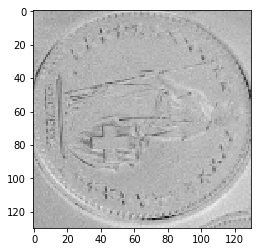

(8, 130, 130, 3) (8L, 1L, 95L) 
[[ 0.          0.21796875  0.05918058  0.25703126  0.15477997  0.
   0.2390625   0.07435508  0.27500001  0.17147192  0.          0.26015624
   0.08649469  0.29609376  0.19119878  0.          0.28359374  0.0986343
   0.31874999  0.19575115  0.          0.30156249  0.10925645  0.33906251
   0.20637329  0.          0.33281249  0.11987861  0.36250001  0.22610015
   0.          0.20156249  0.30500758  0.23828125  0.39757207  0.
   0.22499999  0.30500758  0.26171875  0.39757207  0.          0.18203124
   0.01517451  0.20937499  0.08952959  0.          0.48281249  0.66464341
   0.53750002  0.7192716   0.          0.48984376  0.70257968  0.54453123
   0.76176023  0.          0.51328123  0.77996963  0.56171876  0.84370255
   0.          0.53046876  0.86191201  0.57578123  0.92564493  0.
   0.63749999  0.75265557  0.68046874  0.81031865  0.          0.69375002
   0.93171471  0.73359376  0.98786038  0.          0.54374999  0.89529592
   0.58906251  0.95751137  0.  

In [117]:
import  matplotlib.pyplot as plt
train_data_rec.reset()
for i, batch in enumerate(train_data_rec):
    data = batch.data[0].transpose((0, 2, 3, 1)).asnumpy()
    label = batch.label[0]
    plt.imshow(data[0])
    plt.show()
    print data.shape, label.shape, label[1]
    print label.shape[-1] / 5
    break
